In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [28]:
with open("dataset/breast-cancer.labels", "r") as f:
    labels = [line.strip() for line in f.readlines()]
train_data = pd.io.parsers.read_csv("dataset/breast-cancer-train.dat", names=labels)
validate_data = pd.io.parsers.read_csv("dataset/breast-cancer-validate.dat", names=labels)
train_data_malignant = train_data[train_data["Malignant/Benign"] == "M"]
train_data_benign = train_data[train_data["Malignant/Benign"] == "B"]

In [ ]:
value_train_data_malignant = train_data_malignant[labels[10]].sort_values()
value_train_data_benign = train_data_benign[labels[10]].sort_values()

(array([146.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 10 artists>)

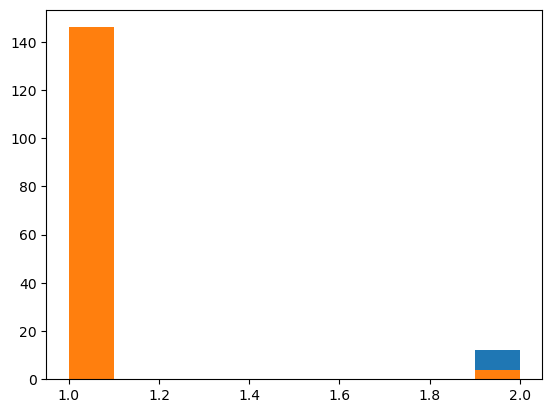

In [30]:
plt.hist(sorted_train_data_malignant)
plt.hist(sorted_train_data_benign)

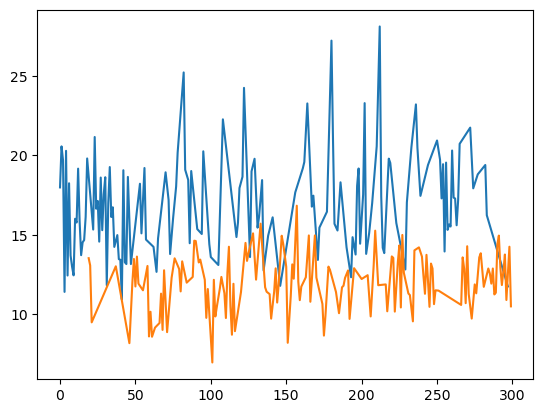

In [31]:
plt.plot(train_data_malignant[labels[2]])
plt.plot(train_data_benign[labels[2]])

In [ ]:
data_set = train_data[["radius (mean)", "perimeter (mean)", "area (mean)", "symmetry (mean)"]]

In [ ]:
print(data_set)

     radius (mean)  perimeter (mean)  area (mean)  symmetry (mean)
0            17.99            122.80       1001.0           0.2419
1            20.57            132.90       1326.0           0.1812
2            19.69            130.00       1203.0           0.2069
3            11.42             77.58        386.1           0.2597
4            20.29            135.10       1297.0           0.1809
..             ...               ...          ...              ...
295          13.77             88.06        582.7           0.1592
296          10.91             69.14        363.7           0.1449
297          11.76             75.00        431.1           0.1619
298          14.26             91.22        633.1           0.1635
299          10.51             66.85        334.2           0.1695

[300 rows x 4 columns]
